#### **Deep & Reinforcement Learning**

#### **Observações**

##### **Classificando cães 🐕 e gatos 🐈**

Você já imaginou criar uma rede neural para classificar imagens? As redes neurais convolucionais (CNNs) são amplamente utilizadas em uma variedade de aplicações de visão computacional e processamento de imagens devido à sua capacidade de aprender representações hierárquicas de dados.

Na aula de hoje vamos criar uma rede neural para classificar cães e gatos. Sabemos que para os olhos humanos é fácil a identificação dos animais por meio de algumas diferenças entre ambos, tal como gatos possuem os olhos mais puxadinhos, orelhinhas mais pontudas e entre outras características. Mas também sabemos que temos cães que podem ter características semelhantes ao gato, tal como a orelhinha pontuda, cauda longa, e entre outras características. Será que a rede neural consegue distinguir os animais? Vamos codar e descobrir juntos!!

##### Classificando notícias com Redes Neurais Recorrentes 📰
Imagine que temos o desafio de organizar diversos tipos de notícias por assuntos, como você faria? Basicamente podemos classificar uma notícia dado algum contexto, por exemplo:

"Pela quarta rodada do Campeonato Italiano, a Roma não tomou conhecimento do Empoli neste domingo e venceu pela primeira vez na competição."

Com base nesse contexto, poderiamos classificar essa notícia como do tipo "Esportes", certo? E por que sabemos disso? Bem, podemos observar algumas palavrinhas chaves tal como "campeonato" e "competição".

Nessa aula, temos o desafio de ensinar uma rede neural recorrente realizar esse tipo de trabalho! Classificar notícias com base em textos.

Como bem já sabemos, as redes neurais recorrentes aprende com ela mesma (assim como nós humanos aprendemos com nossos erros). Basicamente, esse tipo de arquitetura aprende não só com os dados de entrada mas também com as próprias saídas da rede (muito parecido com um looping de aprendizado, por isso chamamos de redes recorrentes). Como nesse cenário precisamos de uma sequência de palavras para fazer sentido ao contexto, as RNNs podem ser uma boa alternativa! Vamos codar? 😀

##### **Como criar ambientes para evitar conflito:**
https://github.com/RicardViana/fiap-data-viz-and-production-models/blob/main/Roteiro%20para%20cria%C3%A7%C3%A3o%20de%20ambiente.pdf

#### **Conteúdo - Bases e Notebook da aula**

Github:  
https://github.com/FIAP/Pos_Tech_DTAT/tree/DeepLearning

ou

https://github.com/FIAP/Pos_Tech_DTAT/tree/main


#### **Importação de bibliotecas**

In [ ]:
#Importar biblioteca completa
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import cv2
import gdown
import config

#Importar algo especifico de uma biblioteca
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import metrics as skm
from tensorflow import keras
from keras import models
from keras import layers
from keras import metrics
from keras.optimizers import Adam
from keras.metrics import Precision
from tqdm.keras import TqdmCallback
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout, Conv2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from pathlib import Path
from distutils.file_util import copy_file
from keras.layers import Input
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.src.legacy.preprocessing.image import ImageDataGenerator

#### **Funções (def)**

In [2]:
def guess_animal(filepath):

    # Declaramos as variáveis que serão criadas ao longo do código
    global model
    global animal_names
    global image_size

    # Lógica robusta para ler caminhos com acentos
    img_array = np.fromfile(str(filepath), np.uint8)
    image = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

    if image is None:
        print("Erro: Não foi possível carregar a imagem.")
        return

    # Processamento
    img = cv2.resize(image, (image_size, image_size)).astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    # Predição
    pred = model.predict(img, verbose=0)
    classes = np.argmax(pred, axis=1)

    # Output
    print(f"Previsão: {animal_names[classes[0]]}")
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [3]:
def guess_animal_transfer_learning(filepath):

    # Declaramos as variáveis que serão criadas ao longo do código
    global model
    global animal_names

    # Lógica robusta para ler caminhos com acentos
    img_array = np.fromfile(str(filepath), np.uint8)
    image = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

    if image is None:
        print("Erro: Não foi possível carregar a imagem.")
        return

    # Processamento
    img = cv2.resize(image, (224, 224)).astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    # Predição
    pred = model.predict(img, verbose=0)
    classes = np.argmax(pred, axis=1)

    # Output
    print(f"Previsão: {animal_names[classes[0]]}")
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

#### **Aula 2 - Redes convolucionais**

In [4]:
# Em vez de montar o drive, lemos o caminho do nosso arquivo de configuração
caminho_da_pasta = config.DATA_PATH
pasta_imagens = Path(caminho_da_pasta)

# Listando todas as imagens do diretório (o seu código original)
filepaths = list(pasta_imagens.glob(r'**/*.jpg'))

# Verificação para garantir que os arquivos foram carregados
if filepaths:
    print(f"Sucesso! Foram encontradas {len(filepaths)} imagens.")
    print(f"Primeira imagem: {filepaths[0]}")
else:
    print("Erro: Nenhuma imagem encontrada. Verifique o caminho no seu arquivo config.py")

Sucesso! Foram encontradas 1400 imagens.
Primeira imagem: C:\Users\ricar\OneDrive\Cursos\Pós Graduação\Data Analytics - FIAP\07 - Fase 5 - Deep Learning and Unstructured Data\02 - Deep & Reinforcement Learning\Outros\cat_dog_imagens\cachorinho\dog.0.jpg


In [5]:
# Inicializando rótulos e listas de imagens para armazenar os dados
labels = [] #armazenando as variáveis target
images = [] #armazenando imagens

# Definindo o tamanho da dimensão da imagem
image_size = 64

# Um loop for para definir as variáveis x e y para os modelos
for filepath in filepaths:

    try:
        
        # Tratar caminho com espaço e acento
        img_array = np.fromfile(str(filepath), np.uint8)

        # Obtem a imagem do caminho com cv2
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

        # Verificação de segurança
        if img is None:
            print(f"⚠️ Arquivo ignorado (não é uma imagem válida): {filepath}")
            continue
            
        # Divide o nome do caminho para extrair o cabeçalho do caminho com split
        head = os.path.split(filepath)

        # Divide o cabeçalho do caminho anterior para extrair o nome do animal
        animal = os.path.split(head[0])

        # Armazena o nome do animal na lista de labels
        labels.append(animal[1])
        
        # Redimensiona a imagem e normalize o intervalo de pixels para ficar entre 0 e 1 (padronização)
        # Utilizando float32 para criar uma precisão limitada (menor demanda de memória em comparação com tipos de ponto flutuante de maior precisão: float64)
        img = cv2.resize(img, (image_size, image_size)).astype('float32') / 255.0

        # Adiciona a imagem na lista de imagens
        images.append(img)
        
    except Exception as e:
        print(f"❌ Erro crítico ao processar {filepath}: {e}")

# Converte a imagem em lista de array
images = np.array(images)

# Converte as labels para lista de array
labels = np.array(labels)

In [6]:
# Consulta o shape da imagem
images.shape

(1400, 64, 64, 3)

In [7]:
# Consultar a lista de array
images

array([[[[0.49411765, 0.44313726, 0.4509804 ],
         [0.5921569 , 0.56078434, 0.5647059 ],
         [0.64705884, 0.6313726 , 0.627451  ],
         ...,
         [0.6509804 , 0.6039216 , 0.59607846],
         [0.6       , 0.5529412 , 0.54509807],
         [0.5803922 , 0.53333336, 0.5254902 ]],

        [[0.5137255 , 0.4627451 , 0.47058824],
         [0.6       , 0.5686275 , 0.57254905],
         [0.64705884, 0.627451  , 0.62352943],
         ...,
         [0.65882355, 0.6117647 , 0.6039216 ],
         [0.63529414, 0.5882353 , 0.5803922 ],
         [0.6       , 0.5529412 , 0.54509807]],

        [[0.53333336, 0.48235294, 0.49019608],
         [0.6       , 0.5686275 , 0.57254905],
         [0.67058825, 0.6509804 , 0.64705884],
         ...,
         [0.6745098 , 0.627451  , 0.61960787],
         [0.63529414, 0.5882353 , 0.5803922 ],
         [0.61960787, 0.57254905, 0.5647059 ]],

        ...,

        [[0.81960785, 0.54509807, 0.5764706 ],
         [0.47058824, 0.33333334, 0.40784314]

In [8]:
# Consultar a lista de array
labels

array(['cachorinho', 'cachorinho', 'cachorinho', ..., 'gatinho',
       'gatinho', 'gatinho'], shape=(1400,), dtype='<U10')

In [9]:
# Construir o data frame

'''

Com as imagens e rotulos já definidos, vamos construir um dataframe com o nome do caminho e o rótulo da imagem.

'''

# Salvando a lista de caminhos de arquivo
pd_filepaths = pd.Series(filepaths, name='Filepath').astype(str)

In [10]:
# Salvando a lista de caminhos de arquivo
pd_filepaths = pd.Series(filepaths, name='Filepath').astype(str)

In [11]:
# Visualizando o camiho das imagens
print(pd_filepaths[:3])

0    C:\Users\ricar\OneDrive\Cursos\Pós Graduação\D...
1    C:\Users\ricar\OneDrive\Cursos\Pós Graduação\D...
2    C:\Users\ricar\OneDrive\Cursos\Pós Graduação\D...
Name: Filepath, dtype: object


In [12]:
# Visualizando os rótulos das imagens
print(labels[:3])

['cachorinho' 'cachorinho' 'cachorinho']


In [13]:
# Adicionando a label
pd_labels = pd.Series(labels, name='Label')

In [14]:
# Concatenando the filepaths and labels
df = pd.concat([pd_filepaths, pd_labels], axis=1)

In [15]:
# Consultando o data frame com o head
df.head()

,Filepath,Label
0,C:\Users\ricar\OneDrive\Cursos\Pós Graduação\D...,cachorinho
1,C:\Users\ricar\OneDrive\Cursos\Pós Graduação\D...,cachorinho
2,C:\Users\ricar\OneDrive\Cursos\Pós Graduação\D...,cachorinho
3,C:\Users\ricar\OneDrive\Cursos\Pós Graduação\D...,cachorinho
4,C:\Users\ricar\OneDrive\Cursos\Pós Graduação\D...,cachorinho


In [16]:
# Consultando o data frame com o head
df.tail()

,Filepath,Label
1395,C:\Users\ricar\OneDrive\Cursos\Pós Graduação\D...,gatinho
1396,C:\Users\ricar\OneDrive\Cursos\Pós Graduação\D...,gatinho
1397,C:\Users\ricar\OneDrive\Cursos\Pós Graduação\D...,gatinho
1398,C:\Users\ricar\OneDrive\Cursos\Pós Graduação\D...,gatinho
1399,C:\Users\ricar\OneDrive\Cursos\Pós Graduação\D...,gatinho


In [17]:
# Embaralhando o dataframe

'''

Como dados estão em ordem das classes, isso pode ser um problema para o modelo, então vamos utilizar o sample para embaralhar o dataframe:

'''

df = df.sample(frac=1).reset_index(drop = True)

In [18]:
# Consultando o data frame com o head
df.head()

,Filepath,Label
0,C:\Users\ricar\OneDrive\Cursos\Pós Graduação\D...,cachorinho
1,C:\Users\ricar\OneDrive\Cursos\Pós Graduação\D...,gatinho
2,C:\Users\ricar\OneDrive\Cursos\Pós Graduação\D...,cachorinho
3,C:\Users\ricar\OneDrive\Cursos\Pós Graduação\D...,cachorinho
4,C:\Users\ricar\OneDrive\Cursos\Pós Graduação\D...,cachorinho


In [19]:
# Cria uma cópia do dataframe com apenas uma imagem de cada animal
# Subset está procurando por duplicatas apenas na coluna chamada 'Label' e removendo todas as duplicatas encontradas.
df_singles = df.copy().drop_duplicates(subset=('Label')).reset_index() 

In [20]:
# Fazer uma contagem
len(df_singles)

2

In [21]:
# Define o número de classes
num_classes = df_singles.shape[0]

In [22]:
# Verificar o numero de classes
num_classes

2

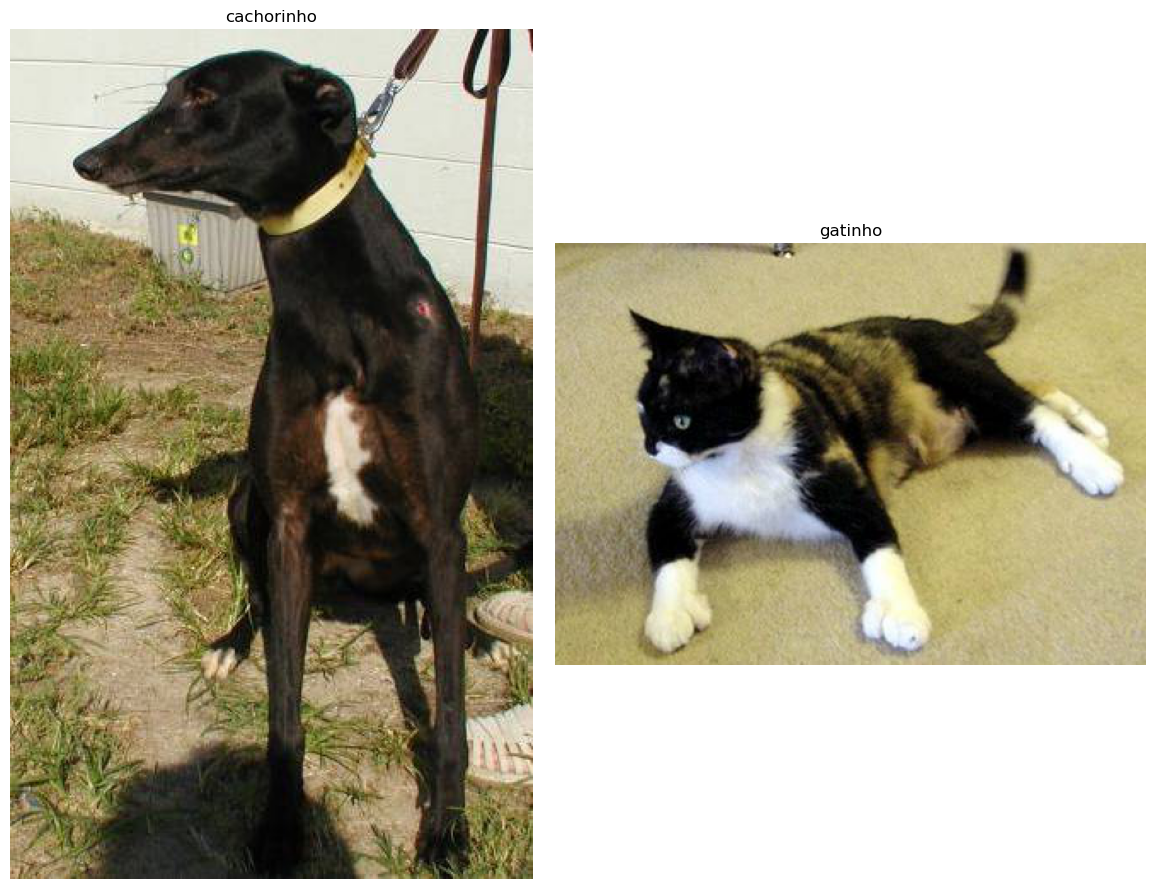

In [23]:
'''

Agora que temos as classes mapeadas na variável num_classes, vamos visualizar duas amostras de imagens dentro do dataset:

'''

# Configura o número de linhas e colunas para visualizar os dados no plot
ROW = 1
COLUMN = 2

# Dimensões das imagens
plt.figure(figsize=(12, 9))
#Loop para cada animal
for i in range(num_classes):
    # Defina uma variável de imagem local para i imagem no dataframe de singles
    image = df_singles.Filepath[i]
    # Define a posição da imagem a ser plotada
    plt.subplot(ROW, COLUMN, i+1)
    # Mostra a imagem
    plt.imshow(plt.imread(image))
    # Adiciona o rótulo do bichinho que corresponde à imagem
    plt.title('{}'.format(df_singles.Label[i]))
    # Desliga o eixo de plotagem
    plt.axis('off')
    # Faça com que o preenchimento ao redor das imagens seja mínimo
    plt.tight_layout()
plt.show()


In [24]:
# Separar em treino e teste a base de dados

'''

Agora com as imagens e classes organizadas, podemos aplicar o train_test_split para separar as bases de treinamento e teste: 

'''

x_train, x_test, y_train, y_test = train_test_split(images,labels, test_size=0.2, stratify=labels, random_state=44)

In [25]:
# Analisando a dimensão dos dados --> x_train
x_train.shape

(1120, 64, 64, 3)

In [26]:
# Analisando a dimensão dos dados --> x_test
x_test.shape

(280, 64, 64, 3)

In [27]:
'''

As imagens são basicamente uma matriz de pixels e para colocar as imagens dentro da arquitetura das redes convolucionais, é preciso "achatar" essas matrizes multidimensionais em vetores unidimensionais. 
Uma das camadas da rede, a Flatten(), é uma das partes da rede que achata os dados antes de entrar nas camadas densas.

'''

# Achatar os dados de teste e treinamento
x_train_flat = x_train.reshape(x_train.shape[0], x_train.shape[1]* x_train.shape[2]* x_train.shape[3])
x_test_flat = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3])

In [28]:
# Visualizando a transformação
x_train_flat.shape

(1120, 12288)

In [29]:
'''

Como próximo passo, vamos converter as classes de texto em binárias. Para esse procedimento, vamos utilizar o método LabelEncoder().

'''

# Converter Strings em Numéricos
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# Converte um vetor de classe (inteiros) em uma matriz de classe categórica.
y_train_tf = keras.utils.to_categorical(y_train, num_classes)
y_test_tf = keras.utils.to_categorical(y_test, num_classes)

In [30]:
'''

Vamos configurar agora como próximo passo o ModelCheckpoint para usar os melhores pesos para este modelo. 
Um dos benefícios do ModelCheckpoint é salvar uma cópia do modelo em disco em intervalos regulares (como após cada época de processamento) para que você possa retomar o treinamento 
a partir do ponto em que parou, minimizando perdas de tempo e recursos computacionais.

'''

# Defina um objeto ModelCheckpoint para usar os melhores pesos para este modelo
#checkpointer = ModelCheckpoint(filepath="weights.best.keras", verbose=0, save_best_only=True) --> Modelo aula

# Definimos o nome do ficheiro
nome_arquivo = "weights.best.keras"

# Criamos o checkpointer
checkpointer = ModelCheckpoint(
    filepath=nome_arquivo,
    monitor='val_accuracy', 
    verbose=1,               
    save_best_only=True,
    mode='max'               
)

print(f"✅ O modelo será monitorizado e salvo em: {os.path.abspath(nome_arquivo)}")


✅ O modelo será monitorizado e salvo em: c:\Users\ricar\OneDrive\Cursos\Pós Graduação\Data Analytics - FIAP\07 - Fase 5 - Deep Learning and Unstructured Data\weights.best.keras


In [31]:
'''

Como próximo passo, vamos definir a entrada da rede e armazenar na variável

input_shape e em seguida configurar a learning rate e a queda do peso do otimizador com **weight_decay**.

O argumento weight_decay é usado para aplicar regularização L2 (também conhecida como regularização de peso) às camadas densas (fully connected) de uma rede neural durante o treinamento. 
A regularização L2 funciona adicionando um termo à função de perda durante o treinamento que penaliza os pesos maiores.

'''

# Define a forma de entrada das imagens passadas pelo modelo
input_shape = (image_size, image_size, 3)

# Defina a taxa de aprendizado e a queda de peso para o otimizador usar
learning_rate = 0.001

# Parametro usado na aula 3 referente a transferência de aprendizagem
# weight_decay = 1e-4

In [32]:
# Gerar a rede neural convolucional

# Defindo uma semente aleatória para utilizar sempre os mesmos dados durante nossos testes
tf.random.set_seed(44)

# Abrindo a sequencia do modelo
model = Sequential()

# Camada de entrada explícita
model.add(Input(shape=input_shape))

# 1 camada convolucional com 128 neurônios | filtro utilizando uma matriz 3x3 sendo movimentado por um stride de 2
# padding ativado (sem bordas de zeros) | função de ativação ReLU | regularização L2 ativada
model.add(Conv2D(128,
                 kernel_size=(3, 3),
                 strides=(2, 2),
                 padding='same',
                 activation='relu',
                 kernel_regularizer=keras.regularizers.l2(0.001)))

# Camada de MaxPolling ativada, com uma matriz 2x2. Padding ativado
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))

# Regularização de dropout ativada
model.add(Dropout(0.5))

# 2 camada convolucional com 92 neurônios | filtro utilizando uma matriz 3x3 sendo movimentado por um stride de 2
# padding ativado (sem bordas de zeros) | função de ativação ReLU | regularização L2 ativada
model.add(Conv2D(92,
                 kernel_size=(3, 3),
                 strides=(2, 2),
                 padding='same',
                 activation='relu',
                 kernel_regularizer=keras.regularizers.l2(0.001)))

# Camada de MaxPolling ativada, com uma matriz 2x2. Padding ativado
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))

# Regularização de dropout ativada
model.add(Dropout(0.5))

# Camada que achata dos dados da imagem
model.add(Flatten())

# Camada Dense da rede neural convolucional + função de ativação ReLU
model.add(Dense(256, activation='relu'))

# Camada de saída da rede, utilizando a função de ativação softmax para criar a probabilidade de pertencimento das classes
model.add(Dense(y_train_tf.shape[1], activation='softmax'))

# Visualizar resumo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 92)       │       106,076 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 92)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 92)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       377,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 487,262 (1.86 MB)

 Trainable params: 487,262 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
'''

Vamos configurar uma técnica de validação do modelo para evitar que as épocas de processamento não executem o modelo sem ter melhoras significativas, o early stopping. 
Essa técnica monitora a perda no conjunto de validação e interrompe o treinamento se a perda não diminuir significativamente por um número especificado de épocas (10 no exemplo)
após uma pequena melhoria (mínimo delta de 1e-5). Essa é uma técnica útil para evitar o overfitting e economizar tempo de treinamento. 
Podemos dizer que essa técnica ajuda o modelo a não ficar "estagnado", ou seja, se encontra em estado estacionário

Além da configuração do early stopping, vamos configurar a função de custo com o Adam. A função de custo tem o papel de ajustar os pesos de uma rede neural durante o treinamento. 
O Adam também utiliza um termo de momentum para acelerar o processo de aprendizado. 
O momentum ajuda o algoritmo a superar regiões planas ou mínimos locais rasos, permitindo que ele "ganhe velocidade" na direção do mínimo global. 
O otimizador Adam requer menos configuração de hiperparâmetro da taxa de aprendizagem, então um valor padrão n = 0,001 pode ser uma boa opção!

Lembrando que a taxa de aprendizagem (learning rate) é responsável por controlar o tamanho dos “passos” das interações para encontrar um melhor mínimo local (menor erro). 
Uma taxa de aprendizagem baixa pode ser mais precisa, porém pode demorar para encontrar o mínimo local. Uma taxa de aprendizado alta pode deixar passar o melhor mínimo local.

'''

# Monitor para interromper o modelo antecipadamente quando a melhoria da perda de validação for mínima
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, verbose=1, mode='auto') #Aqui utilizando early stopping

# Compilando o modelo e aplicação a função de custo Adam (utilizando a learning rate que configuramos anteriormente)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=['accuracy'])

# Salve os dados do modelo em um arquivo keras
model.save('./cat_dog.keras')

print(f"✅ O modelo será monitorizado e salvo em: {os.path.abspath('cat_dog.keras')}")

# Resumo do modelo
model.summary()

✅ O modelo será monitorizado e salvo em: c:\Users\ricar\OneDrive\Cursos\Pós Graduação\Data Analytics - FIAP\07 - Fase 5 - Deep Learning and Unstructured Data\cat_dog.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 92)       │       106,076 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 92)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 92)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       377,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 487,262 (1.86 MB)

 Trainable params: 487,262 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Treinando o modelo
history = model.fit(x_train,y_train_tf, validation_split=0.25, callbacks=[monitor,checkpointer],verbose=1,epochs=45, batch_size=50, shuffle=True)

Epoch 1/45
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5310 - loss: 0.8337
Epoch 1: val_accuracy improved from None to 0.49643, saving model to weights.best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5357 - loss: 0.8105 - val_accuracy: 0.4964 - val_loss: 0.7874
Epoch 2/45
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5188 - loss: 0.7861
Epoch 2: val_accuracy did not improve from 0.49643
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5310 - loss: 0.7799 - val_accuracy: 0.4964 - val_loss: 0.7784
Epoch 3/45
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5076 - loss: 0.7743
Epoch 3: val_accuracy did not improve from 0.49643
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.5131 - loss: 0.7668 - val_accuracy: 0.4893 - val_loss: 0.7590
Epoch 4/45
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5284 - loss: 0.7511
Epoch 4: val_accuracy improved from 0.49643 to 0.50357, saving model to weights.best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 

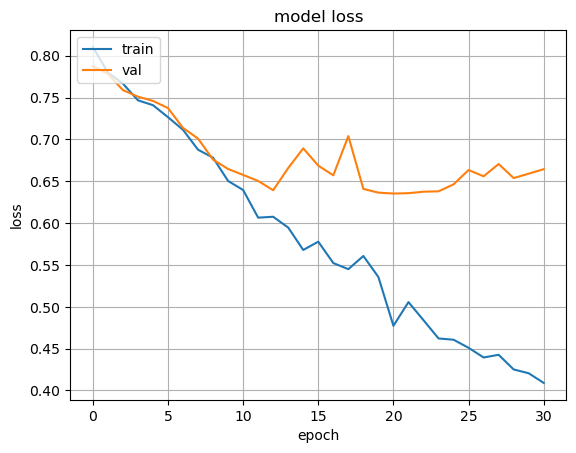

In [35]:
'''

Validação do modelo

Existem duas métricas importantes que devemos analisar após executar a rede neural, o valor de erro observado e o valor de acurácia por épocas de processamento. 
Uma boa prática é analisarmos com gráficos de linhas para identificarmos as tendências da performance da rede.

'''

# Validação o erro por épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()

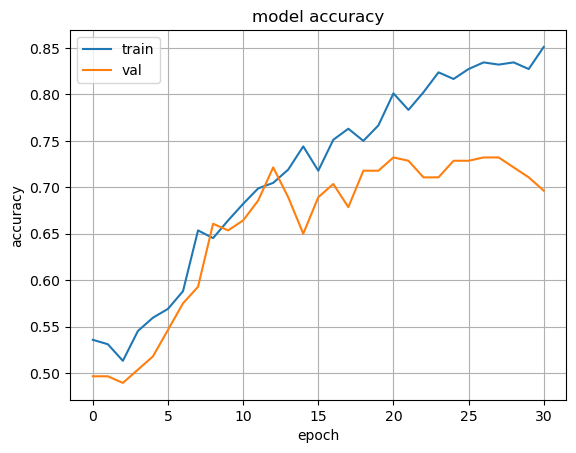

In [36]:
# Validação da acurácia por épocas
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()

In [37]:
'''

Agora vamos armazenar as predições da base de teste na variável de predição cnn_pred_cat_dog

'''

# Armazena as predicações do modelo dos dados de teste em uma variável
cnn_pred_cat_dog = model.predict(x_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [38]:
'''

Vamos utilizar o argmax do numpy para encontrar a classe com a maior probabilidade prevista para cada amostra. (Lembrando que utilizamos a softmax)

'''

# Define o índice do valor máximo do modelo de previsão para uma variável
# O valor máximo indica o caractere de previsão do modelo que a imagem representa
cnn_pred_cat_dog = np.argmax(cnn_pred_cat_dog,axis=1)

# Define uma variável para armazenar o rótulo que representa o resultado verdadeiro
y_true = np.argmax(y_test_tf,axis=1)

In [39]:
'''

Vamos organizar os nomes dos animais (gatinhos e cachorrinhos) em uma variável, a fim de criar uma lista única de nomes de animais, ordenados alfabeticamente. 
Vamos também remover duplicatas e ordenar os nomes em ordem alfabética, resultando em uma lista única, limpa e ordenada de nomes de animais.

'''

# Cria um array de nomes de caracteres igual ao array de labels
animal_names = labels

# Reduza os nomes dos animais para apenas valores dict únicos
animal_names = list(dict.fromkeys(animal_names))

# Ordena os caracteres em ordem alfabética, qual é a ordem em que os dados são alimentados
animal_names = sorted(animal_names)

In [40]:
'''

Importante analisar o escopo das classes, então vamos utilizar o classification_report e analisar os resultados por escopo das variáveis targets.

'''

# Criando a matriz de confusão
cnn_cm_cat_dog = skm.confusion_matrix(y_true, cnn_pred_cat_dog)

# Definindo a acurácia
cnn_accuracy_cat_dog = skm.accuracy_score(y_true, cnn_pred_cat_dog)

# Print do classification report
print(classification_report(y_true, cnn_pred_cat_dog, target_names=animal_names))

# Print da acurácia
print("Accuracy score: {}".format(cnn_accuracy_cat_dog))

              precision    recall  f1-score   support

  cachorinho       0.77      0.77      0.77       140
     gatinho       0.77      0.76      0.77       140

    accuracy                           0.77       280
   macro avg       0.77      0.77      0.77       280
weighted avg       0.77      0.77      0.77       280

Accuracy score: 0.7678571428571429


Previsão: gatinho


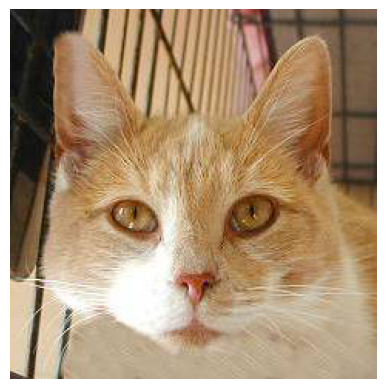

In [41]:
caminho = r"C:\Users\ricar\OneDrive\Cursos\Pós Graduação\Data Analytics - FIAP\07 - Fase 5 - Deep Learning and Unstructured Data\02 - Deep & Reinforcement Learning\Outros\imagens_teste\cat.202.jpg"
guess_animal(caminho)

Previsão: gatinho


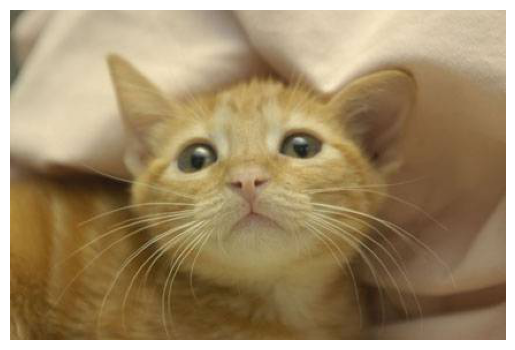

In [42]:
caminho = r"C:\Users\ricar\OneDrive\Cursos\Pós Graduação\Data Analytics - FIAP\07 - Fase 5 - Deep Learning and Unstructured Data\02 - Deep & Reinforcement Learning\Outros\imagens_teste\cat.475.jpg"
guess_animal(caminho)

Previsão: cachorinho


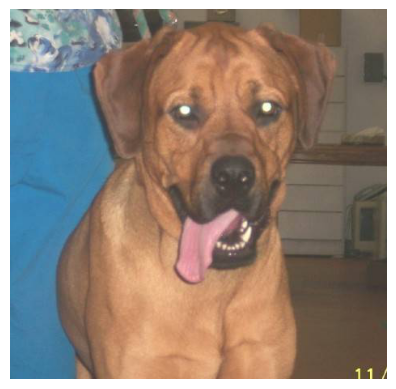

In [43]:
caminho = r"C:\Users\ricar\OneDrive\Cursos\Pós Graduação\Data Analytics - FIAP\07 - Fase 5 - Deep Learning and Unstructured Data\02 - Deep & Reinforcement Learning\Outros\imagens_teste\dog.30.jpg"
guess_animal(caminho)

Previsão: cachorinho


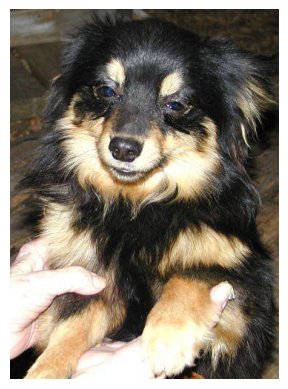

In [44]:
caminho = r"C:\Users\ricar\OneDrive\Cursos\Pós Graduação\Data Analytics - FIAP\07 - Fase 5 - Deep Learning and Unstructured Data\02 - Deep & Reinforcement Learning\Outros\imagens_teste\dog.238.jpg"
guess_animal(caminho)

Previsão: cachorinho


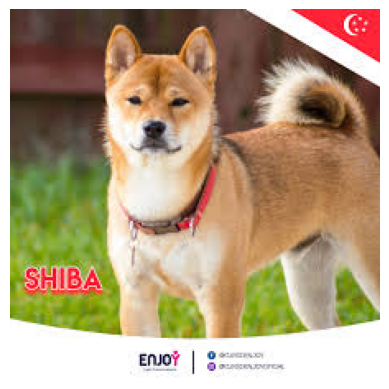

In [45]:
caminho = r"C:\Users\ricar\OneDrive\Cursos\Pós Graduação\Data Analytics - FIAP\07 - Fase 5 - Deep Learning and Unstructured Data\02 - Deep & Reinforcement Learning\Outros\imagens_teste\dog.jpg"
guess_animal(caminho)

#### **Aula 3 - Transferência de aprendizagem**

In [46]:
'''

Criando uma rede neural transfer learning com MobileNetV2 

Problema identificado nas redes neurais CNN construídas do zero:

Perceba aqui que a rede neural CNN para classificar cães e gatos não foi tão eficaz assim. 
Dentro de um dos problemas de deep learning, temos a questão de overfitting que pode ser ocasionada por vários cenários.

Perceba que ao analisar o gráfico da nossa rede neural convolucional, até a 10ª época de processamento, os conjuntos de treinamento e validação 
pareciam andar juntos em questão de performance, mas esse comportamento foi se perdendo ao longo do processamento da rede, nos resultado em 71% de 
acurácia para validação e 84% para treinamento.


Existem muitas formas de reduzir o overfitting em deep learning, tal como técnicas de regularização, batch normalization e também aumentar o tamanho da base 
de treinamento dos dados. Parece muito, mas 1000 imagens podem ser muito pouco para ensinar uma rede neural a aprender os detalhes e particularidades de 
características de imagens. Se utilizarmos por exemplo uma rede neural que já foi treinada com milhares de imagens de amostra, com certeza seu desempenho 
pode melhorar muito. Dentro do treinamento de redes neurais convolucionais, no início da extração de características de imagens, alguns passos podem se tornar
“padrão” em qualquer tipo de imagem, tal como identificação de bordas por exemplo. As camadas iniciais e centrais são aplicadas à aprendizagem por transferência, e as 
últimas camadas são apenas recicladas. A rede faz uso dos dados rotulados da tarefa na qual foi treinado.Se tivermos uma rede neural transfer learning que 
já sabe identificar e muito bem esse tipo de comportamento, podemos ganhar performance e dar um upgrade no nosso modelo e conseguir classificar outros 
tipos de imagens dado o aprendizado obtido.


Solução prospota:

Para dar um upgrade em nossa rede neural, criar uma rede transfer learning utilizando a biblioteca do Keras, a MobileNetV2!
MobileNetV2 é uma arquitetura de rede neural convolucional eficiente que utiliza blocos de gargalo, convoluções separáveis, camadas residuais e outras técnicas para
equilibrar o desempenho e a eficiência de recursos.

Vamos iniciar importando as bibliotecas necessárias do keras para criar a transfer learning e em seguida já começar a construção do modelo. 
Vamos chamar a classe MobileNetV2 e configurar dois hiperparâmetros muito importantes: weights e include_top.

* weights são os pesos da rede que foram treinados pela MobileNetV2.
* include_top exclui a camada final de classificação da rede, ou seja, ela utiliza todo o treinamento aprendido pela MobileNetV2 no conjunto de imagens da ImageNet, 
mas na hora de criar os rótulos, conseguimos criar de forma personalizada de acordo com a nossa rede neural tratada no assunto desejado.

E porque essa rede "pré-treinada" funciona?

Bem, porque alguns passos comuns aprendidos em redes neurais como por exemplo:

* Convoluções de Bordas e Texturas
* Características Complexas de Objetos
* Hierarquia de Características
* Representações de Alto Nível
* Redução da Dimensionalidade

Uma das principais características da MobileNetV2 é sua capacidade de generalização. 
Como foi treinada em um conjunto de dados diversificado e desafiador, ela pode reconhecer uma ampla variedade de objetos e padrões em imagens de entrada.

'''

# Carregue o modelo MobileNetV2 pré-treinado (sem as camadas densas no topo)
# O MobileNetV2 é uma rede neural pré-treinada que foi treinada em um grande conjunto de dados chamado ImageNet, que contém milhões de imagens de várias categorias diferentes.
# weights='imagenet': carregar os pesos pré-treinados da versão do MobileNetV2 que foi treinada no conjunto de dados ImageNet
# include_top=False: excluindo a camada de classificação final (top) da rede. Essa camada de classificação normalmente consiste em uma camada densa (fully connected)
# que produz saídas para cada classe no conjunto de dados original do ImageNet. Excluindo essa camada, você está preparando o modelo para personalizar a camada de classificação para uma nova tarefa.

# Defina o tamanho que você vai usar para as imagens (MobileNetV2 performa bem com 224)
image_size_tl = 224

base_model = MobileNetV2(weights='imagenet', include_top=False,input_shape=(image_size_tl,image_size_tl,3))

# Adicione camadas personalizadas no topo para a classificação de cães e gatos
x = base_model.output

 # reduzir a dimensionalidade dos dados espaciais antes da camada de saída,
x = GlobalAveragePooling2D()(x)

# função de ativação ReLU
x = Dense(128, activation='relu')(x) 

# duas saídas (duas classes, cachorrinhos e gatinhos)
predictions = Dense(2, activation='softmax')(x) 

# Crie o modelo final
model = Model(inputs=base_model.input, outputs=predictions)


In [47]:
'''

Configurar o layer.trainable**

Esse parametro é importante para manter as camadas já treinadas pela MobileNet congelada. 
Aqui todas as camadas do modelo MobileNet pré-treinado são congeladas, e em seguida, camadas personalizadas são adicionadas para realizar a identificação de cães e gatos. 
Durante o treinamento, apenas as camadas personalizadas terão seus pesos ajustados, enquanto as camadas pré-treinadas permanecerão inalteradas. 
Para esse efeito acontecer, devemos configurar esse parâmetro como "False".

'''

# Congelar todas as camadas pré-treinadas
for layer in base_model.layers:
    layer.trainable = False


In [48]:
'''

E chegou o momento de compilar o modelo!

Aqui vamos utilizar a função de custo adam, otimizando assim a identificação do menor erro possível do modelo (loss function).

'''

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [49]:
'''

Como próximo passo, vamos pegar nossas imagens de cães e gatos e "tunar" elas com ImageDataGenerator! 
Essa ferramenta é muito poderosa para aumentar os dados e pré-processar as imagens. 
Ele permite que você crie um fluxo de dados de imagens que pode ser usado para treinar modelos de aprendizado profundo.

'''

# Para evitar problemas de overfitting, usei o ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255, # Normaliza os valores de pixel para o intervalo de 0 a 1.
    rotation_range=20, # Aplica rotações aleatórias de até 20 graus nas imagens.
    width_shift_range=0.2, # Realiza deslocamentos aleatórios horizontal e vertical nas imagens.
    height_shift_range=0.2,
    shear_range=0.2, # corta as bordas
    zoom_range=0.2, # aplica zoom nas imagens
    horizontal_flip=True, # realiza viragens horizontais aleatórias nas imagens.
    fill_mode='nearest' # preenche os pixels que podem ser criados devido a transformações com os valores mais próximos.
)

# Cria a base de treinamento
train_generator = train_datagen.flow_from_directory(
    caminho_da_pasta,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Treine o modelo
model.fit(
    train_generator,
    epochs=5,
)


Found 1400 images belonging to 2 classes.
Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 47s 950ms/step - accuracy: 0.9050 - loss: 0.2138
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9757 - loss: 0.0661
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9786 - loss: 0.0566
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9807 - loss: 0.0487
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9679 - loss: 0.0900


In [ ]:
'''

Rede foi treinada! Agora vamos validar a performance:

'''

caminho_da_pasta_teste = config.DATA_PATH_TESTE

# chamando dados de teste
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    caminho_da_pasta,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Avalie o modelo no conjunto de teste
test_loss, test_acc = model.evaluate(test_generator)
print(f'Acurácia no conjunto de teste: {test_acc}')


Found 1400 images belonging to 2 classes.
17/44 ━━━━━━━━━━━━━━━━━━━━ 19s 716ms/step - accuracy: 0.9932 - loss: 0.0200

In [ ]:
caminho = r"C:\Users\ricar\OneDrive\Cursos\Pós Graduação\Data Analytics - FIAP\07 - Fase 5 - Deep Learning and Unstructured Data\02 - Deep & Reinforcement Learning\Outros\imagens_teste\cat.202.jpg"
guess_animal_transfer_learning(caminho)

In [ ]:
caminho = r"C:\Users\ricar\OneDrive\Cursos\Pós Graduação\Data Analytics - FIAP\07 - Fase 5 - Deep Learning and Unstructured Data\02 - Deep & Reinforcement Learning\Outros\imagens_teste\cat.475.jpg"
guess_animal_transfer_learning(caminho)

In [ ]:
caminho = r"C:\Users\ricar\OneDrive\Cursos\Pós Graduação\Data Analytics - FIAP\07 - Fase 5 - Deep Learning and Unstructured Data\02 - Deep & Reinforcement Learning\Outros\imagens_teste\dog.30.jpg"
guess_animal_transfer_learning(caminho)

In [ ]:
caminho = r"C:\Users\ricar\OneDrive\Cursos\Pós Graduação\Data Analytics - FIAP\07 - Fase 5 - Deep Learning and Unstructured Data\02 - Deep & Reinforcement Learning\Outros\imagens_teste\dog.238.jpg"
guess_animal_transfer_learning(caminho)

In [ ]:
caminho = r"C:\Users\ricar\OneDrive\Cursos\Pós Graduação\Data Analytics - FIAP\07 - Fase 5 - Deep Learning and Unstructured Data\02 - Deep & Reinforcement Learning\Outros\imagens_teste\dog.jpg"
guess_animal_transfer_learning(caminho)